In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter

In [ ]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

In [24]:
path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

## Dropping duplicates prioritizing classes with higher frequency

In [25]:
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [26]:
df['class_freq'] = df['Interaction'].map(interaction_counts)
df = df.sort_values('class_freq', ascending=False)

columns_to_check = df.columns[:-2]
df = df.drop_duplicates(subset=columns_to_check, keep='last')
df = df.drop(columns=['class_freq'])

print("\nClass counts after deduplication:")
print(df['Interaction'].value_counts())


Class counts after deduplication:
Interaction
Unclassified    1089547
VDW              693266
HBOND            673450
PIPISTACK         37885
IONIC             35391
PICATION           8529
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [27]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')

In [28]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_12333/1592439739.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [29]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [30]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          15355
s_psi           5727
s_3di_state    31563
t_rsa             73
t_phi           5556
t_psi          18133
t_3di_state    37305
dtype: int64

Total missing values: 113775


In [31]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

      s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  \
753   0.000 -1.093 -0.664 -1.019 -0.987 -1.505  1.266 -0.912          1.0   
1006  0.074  1.540 -0.085 -0.663 -1.524  2.219 -1.005  1.212         12.0   
418   0.180 -1.672 -0.253  0.260  0.830  3.097 -0.838  1.512         17.0   
413   0.294 -1.322 -0.254  1.050  0.302 -3.656 -0.259 -3.242         17.0   
412   0.049 -2.677  2.662 -1.337 -0.279 -0.544  1.242 -1.262          6.0   

      t_rsa  t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
753   0.893  1.168  0.631  1.831 -0.561  0.533 -0.277  1.648         12.0   
1006  0.028 -1.133 -0.543 -1.337 -0.279 -0.544  1.242 -1.262         17.0   
418   0.346 -1.801  0.850  1.831 -0.561  0.533 -0.277  1.648         12.0   
413   0.586  1.139  0.414  0.945  0.828  1.299 -0.169  0.933         14.0   
412   0.229 -2.085  2.109 -0.663 -1.524  2.219 -1.005  1.212          0.0   

      s_ss8_encoded  t_ss8_encod

In [32]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
# UPDATE WITH NEW ENGINEERED FEATURES
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

## Feature engineering


*   Sum
*   Product
*   Absolute difference
*   Average



In [ ]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names


In [ ]:
for feature in features:
  feature_names.extend(fe(feature))

## Scaling features

In [33]:
# Scale all features to the range [0, 1]
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)
input_dim = X_scaled.shape[1]

In [34]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y,
    stratify=y,
    test_size=0.1,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.1,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [13]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 545494
1: 561545
2: 30687
3: 28667
4: 6908
5: 1701
6: 1450
7: 882533


In [18]:
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Oversample minority classes
oversample_strategy = {
    2: 150000,
    3: 150000,
    4: 100000,
    5: 75000,
    6: 75000
}
oversample = SMOTE(sampling_strategy=oversample_strategy, random_state=42)
X_oversampled, y_oversampled = oversample.fit_resample(X_train, y_train)

# Step 2: Undersample the majority class
undersample_strategy = {7: 700000}  # Reduce Unclassified class
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train, y_train = undersample.fit_resample(X_oversampled, y_oversampled)

In [14]:
sampling_strategy = {
    0: 545494,     # Keep HBOND as is
    1: 561545,     # Keep VDW as is
    2: 150000,     # Increase PIPISTACK moderately
    3: 150000,     # Increase IONIC moderately
    4: 100000,     # More significant increase for PICATION
    5: 75000,      # Substantial increase for SSBOND
    6: 75000,      # Substantial increase for PIHBOND
    7: 700000      # Slightly reduce the Unclassified class
}


oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train, y_train = oversample.fit_resample(X_train, y_train)

# np.save('X_train_smote.npy', X_train)
# np.save('y_train_smote.npy', y_train)

ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 882533 samples and 700000 samples are asked.

In [19]:
#X_train_smote = np.load('X_train_smote.npy')
#y_train_smote = np.load('y_train_smote.npy')

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train)):
    print(f"{label}: {Counter(y_train)[label]}")


Resampled y_train_bal distribution
0: 545494
1: 561545
2: 150000
3: 150000
4: 100000
5: 75000
6: 75000
7: 700000


## XGBoost

### Helper functions

In [35]:
def feature_importance(model, feature_names):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'

  # Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [36]:
import time

def evaluate_model(model, X_test, y_test, feature_names, selected_feature_indices=None):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    """

    # If selected_feature_indices is provided, filter the test data
    if selected_feature_indices is not None:
        X_test = X_test[:, selected_feature_indices]
    # Convert test data to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test, y_pred),
            balanced_accuracy_score(y_test, y_pred),
            roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),
            matthews_corrcoef(y_test, y_pred),
            average_precision_score(y_test, y_pred_prob),
            inference_time * 1000,
        ]
    }

    # Create a DataFrame for metrics
    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics =====")
    print(metrics_df.set_index('Metric').round(4))

    cm = confusion_matrix(y_test, y_pred)
    labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"\n===== Feature Importance =====")

    # 8. Feature importance
    feature_importance(model, feature_names)

    return metrics_df, y_pred_prob

### Train loop

/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:18:34] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	mlogloss-mlogloss:2.03690	mlogloss-merror:0.31615
[1]	mlogloss-mlogloss:1.99725	mlogloss-merror:0.30925
[2]	mlogloss-mlogloss:1.95972	mlogloss-merror:0.30668
[3]	mlogloss-mlogloss:1.92358	mlogloss-merror:0.30302
[4]	mlogloss-mlogloss:1.88996	mlogloss-merror:0.30365
[5]	mlogloss-mlogloss:1.85782	mlogloss-merror:0.30183
[6]	mlogloss-mlogloss:1.82764	mlogloss-merror:0.30259
[7]	mlogloss-mlogloss:1.79892	mlogloss-merror:0.30378
[8]	mlogloss-mlogloss:1.77056	mlogloss-merror:0.30261
[9]	mlogloss-mlogloss:1.74378	mlogloss-merror:0.30247
[10]	mlogloss-mlogloss:1.71837	mlogloss-merror:0.30082
[11]	mlogloss-mlogloss:1.69473	mlogloss-merror:0.30296
[12]	mlogloss-mlogloss:1.67103	mlogloss-merror:0.30420
[13]	mlogloss-mlogloss:1.64817	mlogloss-merror:0.30482
[14]	mlogloss-mlogloss:1.62630	mlogloss-merror:0.30444
[15]	mlogloss-mlogloss:1.60524	mlogloss-merror:0.30328
[16]	mlogloss-mlogloss:1.58457	mlogloss-merror:0.30158
[17]	mlogloss-mlogloss:1.56473	mlogloss-merror:0.30161
[18]	mlogloss-mloglo

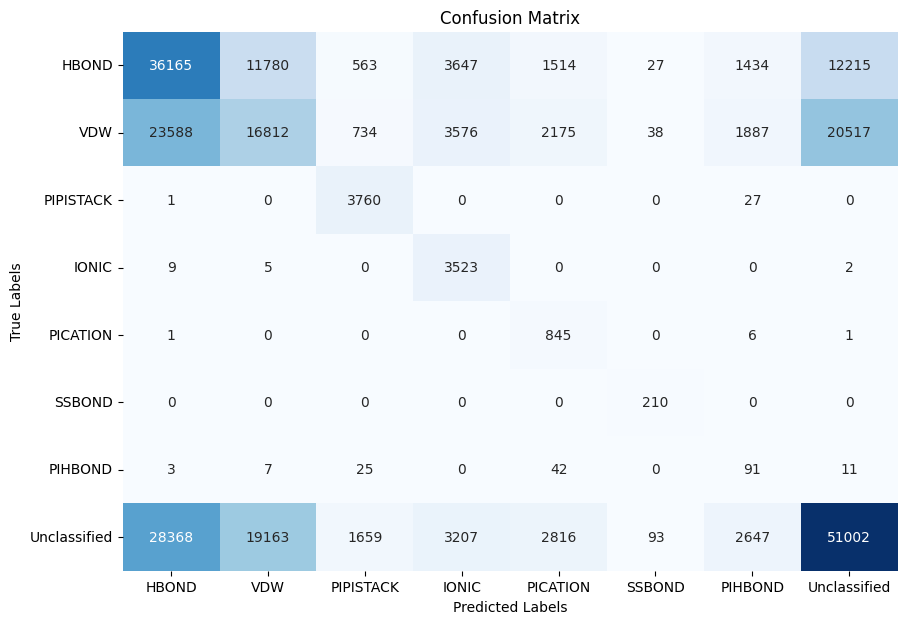


===== Feature Importance =====


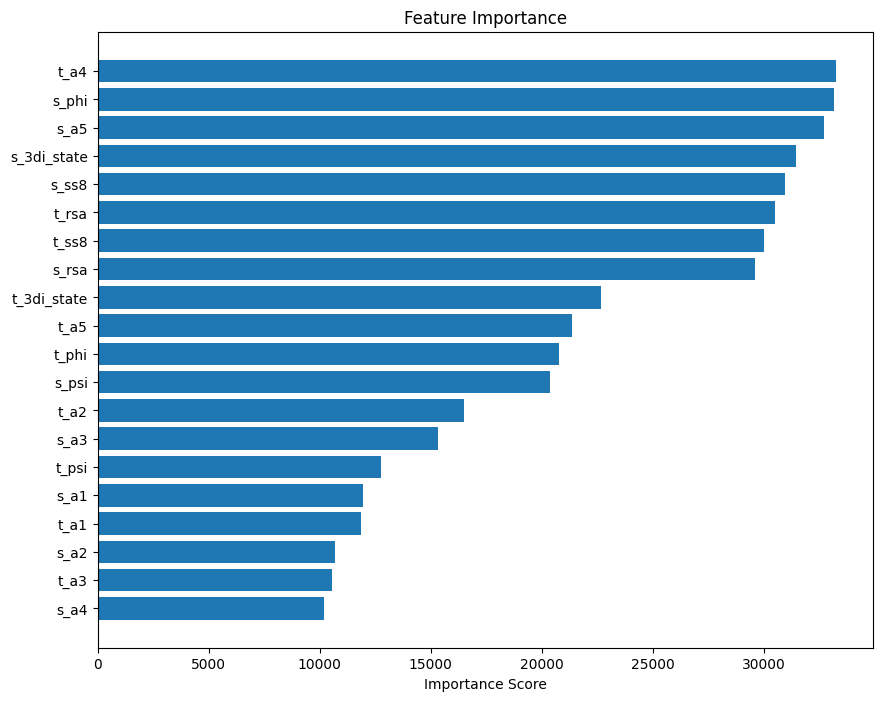

(                 Metric        Value
 0              Accuracy     0.442210
 1     Balanced Accuracy     0.716838
 2               AUC-ROC     0.857549
 3  Matthews Correlation     0.223601
 4     Average Precision     0.428145
 5   Inference Time (ms)  9700.666189,
 array([[3.2252961e-01, 3.2226515e-01, 3.7381338e-04, ..., 3.6591239e-04,
         2.4234222e-03, 3.5129550e-01],
        [3.3399305e-01, 3.3741102e-01, 3.7745177e-04, ..., 3.7319722e-04,
         1.2277156e-03, 3.2563475e-01],
        [4.0035951e-01, 3.3497596e-01, 5.0440087e-04, ..., 4.9827038e-04,
         2.8767416e-02, 2.0890689e-01],
        ...,
        [1.9584288e-01, 3.0466279e-01, 2.9411798e-04, ..., 2.8806209e-04,
         4.5617420e-04, 4.9786985e-01],
        [2.4735333e-01, 3.5764316e-01, 9.5447723e-04, ..., 8.0150960e-04,
         5.5412520e-03, 3.8673922e-01],
        [1.9309205e-01, 3.4395689e-01, 3.8847441e-04, ..., 3.8423078e-04,
         8.2071853e-04, 4.6057463e-01]], shape=(254196, 8), dtype=float32))

In [22]:
weights_train = compute_sample_weight('balanced', y_train)
weights_val = compute_sample_weight('balanced', y_val)

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights_train)
# dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val, weight=weights_val)

# Train model
model = xgb.train(
    params = {
        'device': 'cuda',
        'seed': 42,
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'eval_metric': ['mlogloss', 'merror'],  # Track both
        'max_depth': 8,
        'learning_rate': 0.02,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'min_child_weight': 5,  # Helps with imbalance
    },
    dtrain=dtrain,
    num_boost_round=10000,
    evals=[(dval, 'mlogloss')],
    early_stopping_rounds=50,
    verbose_eval=1
)

# Save model
os.makedirs(os.path.join(path, 'models/mcc_models'), exist_ok=True)
model.save_model(os.path.join(path, f'models/mcc_models/xgboost_model_mcc.json'))

evaluate_model(model, X_test, y_test, feature_names)


## Pruning models

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from collections import defaultdict

def analyze_xgboost_model(model_path):
    """Analyze an XGBoost model JSON file and extract useful information."""
    with open(model_path, 'r') as f:
        model_data = json.load(f)

    # Extract basic model information
    results = {}

    # Model metadata and version
    results['version'] = '.'.join(map(str, model_data.get('learner', {}).get('version', ["unknown"])))

    # Model attributes (parameters)
    attributes = model_data.get('learner', {}).get('attributes', {})
    results['best_iteration'] = int(attributes.get('best_iteration', -1))
    results['best_score'] = float(attributes.get('best_score', -1))

    # Extract hyperparameters
    for key in ['max_depth', 'learning_rate', 'objective', 'eval_metric', 'num_class',
                'scale_pos_weight', 'seed', 'num_parallel_tree', 'subsample', 'colsample_bytree']:
        if key in attributes:
            try:
                value = attributes[key]
                # Convert numeric strings to proper types
                if isinstance(value, str) and value.replace('.', '', 1).isdigit():
                    if '.' in value:
                        results[key] = float(value)
                    else:
                        results[key] = int(value)
                else:
                    results[key] = value
            except:
                results[key] = attributes[key]

    # Extract tree information
    tree_model = model_data.get('learner', {}).get('gradient_booster', {}).get('model', {})

    # Tree model parameters
    gbtree_params = tree_model.get('gbtree_model_param', {})
    results['num_trees'] = int(gbtree_params.get('num_trees', 0))

    # Trees analysis
    trees = tree_model.get('trees', [])

    # Tree statistics
    tree_stats = []
    total_nodes = 0
    total_leaves = 0
    used_features = set()
    feature_importance = defaultdict(int)

    for i, tree in enumerate(trees):
        tree_param = tree.get('tree_param', {})
        num_nodes = int(tree_param.get('num_nodes', 0))
        split_indices = tree.get('split_indices', [])

        # Calculate leaves (nodes that are not internal nodes)
        internal_nodes = set()
        for j in range(len(tree.get('left_children', []))):
            if tree['left_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)
            if tree['right_children'][j] >= 0:  # Not a leaf
                internal_nodes.add(j)

        num_leaves = num_nodes - len(internal_nodes)

        # Track feature usage as a simple feature importance
        for feature_idx in split_indices:
            used_features.add(feature_idx)
            feature_importance[feature_idx] += 1

        # Store tree statistics
        tree_stats.append({
            'tree_index': i,
            'num_nodes': num_nodes,
            'num_leaves': num_leaves,
            'max_depth': max_tree_depth(tree),
            'num_features_used': len(set(split_indices))
        })

        total_nodes += num_nodes
        total_leaves += num_leaves

    results['total_nodes'] = total_nodes
    results['total_leaves'] = total_leaves
    results['avg_nodes_per_tree'] = total_nodes / results['num_trees'] if results['num_trees'] > 0 else 0
    results['avg_leaves_per_tree'] = total_leaves / results['num_trees'] if results['num_trees'] > 0 else 0
    results['num_features_used'] = len(used_features)

    # Sort feature importance
    results['top_features'] = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]

    # Compute tree depth statistics
    depths = [stat['max_depth'] for stat in tree_stats]
    results['min_tree_depth'] = min(depths) if depths else 0
    results['max_tree_depth'] = max(depths) if depths else 0
    results['avg_tree_depth'] = sum(depths) / len(depths) if depths else 0

    # File metrics
    results['file_size_kb'] = os.path.getsize(model_path) / 1024

    return results, tree_stats

def max_tree_depth(tree):
    """Calculate the maximum depth of a tree by following child nodes."""
    left = tree.get('left_children', [])
    right = tree.get('right_children', [])

    if not left or not right:
        return 0

    # Use BFS to find the maximum depth
    depths = {0: 0}  # node_id: depth
    max_depth = 0

    for node_id in range(len(left)):
        node_depth = depths.get(node_id, 0)

        # Process left child
        if left[node_id] >= 0:  # Valid node
            depths[left[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)

        # Process right child
        if right[node_id] >= 0:  # Valid node
            depths[right[node_id]] = node_depth + 1
            max_depth = max(max_depth, node_depth + 1)

    return max_depth

# Usage example
models_dir = '/Users/sebastianosanson/Development/Contacts-Classification/models'
all_model_results = []
all_tree_stats = []

# Process all model files
for filename in sorted(os.listdir(models_dir)):
    if filename.endswith('.json'):
        model_path = os.path.join(models_dir, filename)
        class_num = int(filename.split('_')[-1].split('.')[0])

        # Extract model information
        model_info, tree_stats = analyze_xgboost_model(model_path)
        model_info['class'] = class_num

        # Add model information to results
        all_model_results.append(model_info)

        # Add tree statistics with model identifier
        for stat in tree_stats:
            stat['class'] = class_num
            all_tree_stats.append(stat)

# Create DataFrame for easy analysis
models_df = pd.DataFrame(all_model_results)
trees_df = pd.DataFrame(all_tree_stats)

# Print the high-level model information
print("\n===== MODEL INFORMATION =====")
print(models_df[['class', 'num_trees', 'best_iteration', 'best_score',
                 'total_nodes', 'avg_nodes_per_tree', 'avg_tree_depth',
                 'file_size_kb']].sort_values('class'))

# Print tree depth statistics
print("\n===== TREE DEPTH STATISTICS =====")
tree_depth_stats = trees_df.groupby('class').agg({
    'max_depth': ['min', 'max', 'mean']
}).reset_index()
print(tree_depth_stats)

# Feature importance across models
print("\n===== TOP FEATURES BY CLASS =====")
for i, model in enumerate(all_model_results):
    print(f"\nClass {model['class']} top features:")
    for feature_idx, count in model['top_features'][:]:
        print(f"  Feature {feature_names[feature_idx]}: used {count} times")

In [ ]:
# import xgboost as xgb
# import numpy as np
# import pandas as pd
# from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
# from sklearn.metrics import matthews_corrcoef, average_precision_score
# import matplotlib.pyplot as plt
# import time

# def evaluate_model_comparison(original_model_path, pruned_model_path, X_test, y_test, class_num):
#     """
#     Compare performance between original and pruned XGBoost models.

#     Parameters:
#     -----------
#     original_model_path: str
#         Path to the original model file
#     pruned_model_path: str
#         Path to the pruned model file
#     X_test: numpy array
#         Test features
#     y_test: numpy array
#         Test labels
#     class_num: int
#         Class number for binary evaluation
#     """
#     # 1. Load both models
#     original_model = xgb.Booster()
#     original_model.load_model(original_model_path)

#     pruned_model = xgb.Booster()
#     pruned_model.load_model(pruned_model_path)

#     # 2. Convert test data to DMatrix
#     dtest = xgb.DMatrix(X_test)

#     # 3. Make predictions
#     # Convert to binary task (1 for current class, 0 for other classes)
#     y_test_binary = (y_test == class_num).astype(int)

#     # Get predictions from both models
#     start_time = time.time()
#     y_pred_orig = original_model.predict(dtest)
#     orig_time = time.time() - start_time

#     start_time = time.time()
#     y_pred_pruned = pruned_model.predict(dtest)
#     pruned_time = time.time() - start_time

#     # 4. Convert probabilities to binary predictions
#     y_pred_orig_binary = (y_pred_orig > 0.5).astype(int)
#     y_pred_pruned_binary = (y_pred_pruned > 0.5).astype(int)

#     # 5. Calculate metrics
#     metrics = {
#         'Model': ['Original', 'Pruned'],
#         'Accuracy': [
#             accuracy_score(y_test_binary, y_pred_orig_binary),
#             accuracy_score(y_test_binary, y_pred_pruned_binary)
#         ],
#         'Balanced Accuracy': [
#             balanced_accuracy_score(y_test_binary, y_pred_orig_binary),
#             balanced_accuracy_score(y_test_binary, y_pred_pruned_binary)
#         ],
#         'AUC-ROC': [
#             roc_auc_score(y_test_binary, y_pred_orig),
#             roc_auc_score(y_test_binary, y_pred_pruned)
#         ],
#         'Matthews Correlation': [
#             matthews_corrcoef(y_test_binary, y_pred_orig_binary),
#             matthews_corrcoef(y_test_binary, y_pred_pruned_binary)
#         ],
#         'Average Precision': [
#             average_precision_score(y_test_binary, y_pred_orig),
#             average_precision_score(y_test_binary, y_pred_pruned)
#         ],
#         'Inference Time (ms)': [
#             orig_time * 1000,
#             pruned_time * 1000
#         ]
#     }

#     # Calculate file size
#     import os
#     metrics['Model Size (KB)'] = [
#         os.path.getsize(original_model_path) / 1024,
#         os.path.getsize(pruned_model_path) / 1024
#     ]

#     # 6. Create a DataFrame for metrics
#     metrics_df = pd.DataFrame(metrics)

#     # 7. Calculate performance difference
#     diff_row = {
#         'Model': 'Difference (%)',
#         'Accuracy': (metrics['Accuracy'][1] - metrics['Accuracy'][0]) / metrics['Accuracy'][0] * 100,
#         'Balanced Accuracy': (metrics['Balanced Accuracy'][1] - metrics['Balanced Accuracy'][0]) / metrics['Balanced Accuracy'][0] * 100,
#         'AUC-ROC': (metrics['AUC-ROC'][1] - metrics['AUC-ROC'][0]) / metrics['AUC-ROC'][0] * 100,
#         'Matthews Correlation': (metrics['Matthews Correlation'][1] - metrics['Matthews Correlation'][0]) / max(0.0001, metrics['Matthews Correlation'][0]) * 100,
#         'Average Precision': (metrics['Average Precision'][1] - metrics['Average Precision'][0]) / metrics['Average Precision'][0] * 100,
#         'Inference Time (ms)': (metrics['Inference Time (ms)'][1] - metrics['Inference Time (ms)'][0]) / metrics['Inference Time (ms)'][0] * 100,
#         'Model Size (KB)': (metrics['Model Size (KB)'][1] - metrics['Model Size (KB)'][0]) / metrics['Model Size (KB)'][0] * 100
#     }
#     metrics_df = pd.concat([metrics_df, pd.DataFrame([diff_row])], ignore_index=True)

#     print(f"\n===== Performance Comparison for Class {class_num} =====")
#     print(metrics_df.round(4))

#     # 8. Plot prediction correlation
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_pred_orig, y_pred_pruned, alpha=0.3)
#     plt.plot([0, 1], [0, 1], 'r--')
#     plt.xlabel('Original Model Predictions')
#     plt.ylabel('Pruned Model Predictions')
#     plt.title(f'Prediction Correlation for Class {class_num}')
#     plt.grid(True, alpha=0.3)
#     correlation = np.corrcoef(y_pred_orig, y_pred_pruned)[0, 1]
#     plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes)
#     plt.show()

#     return metrics_df

# # Example usage
# # class_num = 0  # For HBOND class
# # original_path = '/Users/sebastianosanson/Development/Contacts-Classification/models/xgboost_model_class_0.json'
# # pruned_path = '/Users/sebastianosanson/Development/Contacts-Classification/models/xgboost_model_class_0_pruned.json'
# # results = evaluate_model_comparison(original_path, pruned_path, X_test, y_test, class_num)

## Feature Selection

In [ ]:
model_path = 'models/mcc_models/xgboost_model_mcc.json'
model = xgb.Booster()
model.load_model(model_path)

# Get feature importances as a dictionary
importance = model.get_score(importance_type='weight')

# Extract the importance values and calculate their mean
if importance:
    importance_values = np.array(list(importance.values()))
    threshold = np.mean(importance_values)
    print(f"Feature importance threshold: {threshold:.4f}")
else:
    print(f"Warning: No feature importance scores found for the model. Skipping feature selection.")
    # You can exit or continue with all features

# Get features sorted by importance
sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)
print(f"Total features with importance scores: {len(sorted_importance)}")

# Select features based on the threshold
selected_feature_indices = [int(key[1:]) for key, score in sorted_importance if score > threshold]

if not selected_feature_indices:
    print(f"Warning: No features selected with threshold {threshold}. Using top 10 features instead.")
    # Fallback to top N features if threshold yields no features
    selected_feature_indices = [int(key[1:]) for key, _ in sorted_importance[:10]]

# Ensure selected_feature_indices are within bounds
max_feature_index = X_train.shape[1] - 1
selected_feature_indices = [idx for idx in selected_feature_indices if idx <= max_feature_index]

print(f"Selected {len(selected_feature_indices)} features out of {X_train.shape[1]}")

# Filter training/test data using selected indices
X_train_selected = X_train[:, selected_feature_indices]
X_test_selected = X_test[:, selected_feature_indices]
X_val_selected = X_val[:, selected_feature_indices]

# Print selected feature names if available
try:
    selected_features_names = [feature_names[idx] for idx in selected_feature_indices]
    print(f"Top 10 selected features: {selected_features_names[:10]}")
except NameError:
    print(f"Top 10 selected feature indices: {selected_feature_indices[:10]}")
    print("Cannot retrieve feature names: 'feature_names' variable not found.")

# Create DMatrix objects with multi-class labels
# Note: For multi-class, we keep the original labels (not binary)
dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
dval_selected = xgb.DMatrix(X_val_selected, label=y_val)

# Train the pruned multi-class model
num_classes = len(np.unique(y_train))
fs_model = xgb.train(
    params={
        'device': 'cuda',
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'eval_metric': ['mlogloss', 'merror'],
        'max_depth': 10,
        'learning_rate': 0.1,
        'seed': 42
    },
    dtrain=dtrain_selected,
    num_boost_round=model.best_iteration + 1 if hasattr(model, 'best_iteration') else 100,
    evals=[(dval_selected, 'eval')],
    verbose_eval=100
)

evaluate_model(fs_model, X_test_selected, y_test, feature_names, selected_feature_indices=None)

# # Evaluate the new multi-class model
# # For multi-class, predict returns probabilities for each class
# y_pred_selected_prob = fs_model.predict(dtest_selected)
# # Convert probabilities to class predictions
# y_pred_selected = np.argmax(y_pred_selected_prob, axis=1)

# # Calculate multi-class metrics
# selected_accuracy = accuracy_score(y_test, y_pred_selected)
# selected_bal_accuracy = balanced_accuracy_score(y_test, y_pred_selected)
# selected_mcc = matthews_corrcoef(y_test, y_pred_selected)
# selected_auc_roc = roc_auc_score(y_test, y_pred_selected_prob)
# selected_ap = average_precision_score(y_test, y_pred_selected_prob, average='macro')

# print("\n----- Model Performance with Selected Features -----")
# print(f"Accuracy: {selected_accuracy:.4f}")
# print(f"Balanced Accuracy: {selected_bal_accuracy:.4f}")
# print(f"Matthews Correlation Coefficient: {selected_mcc:.4f}")
# print(f"AUC-ROC: {selected_auc_roc:.4f}")
# print(f"Average Precision: {selected_ap:.4f}")

# Save the pruned model
output_dir = 'models/mcc_models_pruned_mean_threshold'
os.makedirs(output_dir, exist_ok=True)
fs_model.save_model(os.path.join(output_dir, 'xgboost_model_multiclass_pruned.json'))
print(f"Pruned model saved to {os.path.join(output_dir, 'xgboost_model_multiclass_pruned.json')}")